# Sheet 6

## 1 Autoencoders: theory and practice

### a)

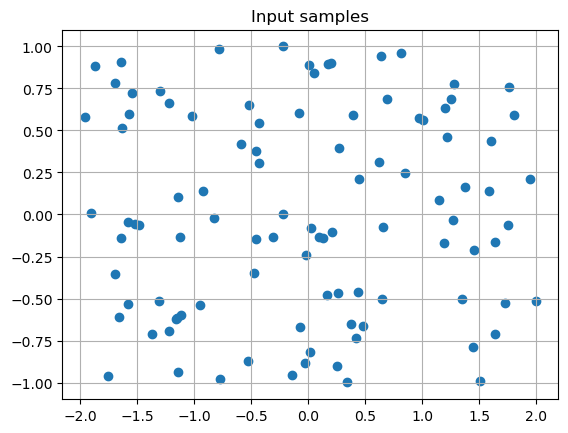

In [1]:
import torch
import matplotlib.pyplot as plt

# create 100 uniform samples from a rectangle [-2, 2] x [-1, 1]
num_samples = 100
data = torch.zeros(num_samples, 2)
data[:, 0] = torch.rand(num_samples) * 4 - 2
data[:, 1] = torch.rand(num_samples) * 2 - 1

# plot the samples
plt.scatter(data[:, 0], data[:, 1])
plt.title("Input samples")
plt.grid(True)
plt.show()

In [2]:
from torch.utils.data import DataLoader, TensorDataset

# Prepare data loader
dataset = TensorDataset(data, data)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)

# get batched data from the data loader
x, y = next(iter(data_loader))
print("x.shape:", x.shape)
print("y.shape:", y.shape)
print("all x == y:", torch.all(x == y).item())

x.shape: torch.Size([8, 2])
y.shape: torch.Size([8, 2])
all x == y: True


In [3]:
# TODO: define the Autoencoder architecture

import torch
from torch import nn
import pytorch_lightning as pl

class Autoencoder(nn.Module):
    def __init__(self, hidded_channels='AE1', latent_dim=1, input_dim=2):
        super().__init__()

        # TODO: implement the encoder and decoder
        if hidded_channels == 'AE1':
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, 20),
                nn.ReLU(),
                nn.Linear(20, 10),
                nn.ReLU(),
                nn.Linear(10, latent_dim),
            )
            self.decoder = nn.Sequential(
                nn.Linear(latent_dim, 10),
                nn.ReLU(),
                nn.Linear(10, 20),
                nn.ReLU(),
                nn.Linear(20, input_dim),
            )
        elif hidded_channels == 'AE2':
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, 50),
                nn.ReLU(),
                nn.Linear(50, 50),
                nn.ReLU(),
                nn.Linear(50, latent_dim),
            )
            self.decoder = nn.Sequential(
                nn.Linear(latent_dim, 50),
                nn.ReLU(),
                nn.Linear(50, 50),
                nn.ReLU(),
                nn.Linear(50, input_dim),
            )
        elif hidded_channels == 'PCA':
            self.encoder = nn.Linear(input_dim, latent_dim)
            self.decoder = nn.Linear(latent_dim, input_dim)
        else:
            raise ValueError('hidded_channels must be in {\'AE1\', \'AE2\', \'PCA\'}')

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class AutoencoderModule(pl.LightningModule):
    def __init__(self, **model_kwargs):
        super().__init__()
        self.autoencoder = Autoencoder(**model_kwargs)
        self.loss_curve = []

    def forward(self, x):
        return self.autoencoder(x)

    def configure_optimizers(self):
        # as default use Adam optimizer:
        optimizer = torch.optim.Adam(self.parameters())

        return optimizer
    
    def on_train_start(self):
        self.loss_curve = []
        return super().on_train_start()

    def training_step(self, batch):
        x, _ = batch
        x_hat = self.autoencoder(x)
        loss = nn.MSELoss()(x_hat, x)
        self.loss_curve.append(loss.item())
        return loss

### b)

In [4]:
# start the training using a PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=1000)
# Autoencoder 1: {20,10,1,10,20,2}
autoencoder_module = AutoencoderModule(hidded_channels='AE1', latent_dim=1, input_dim=2)  # TODO: specify the model here
print("Model overview:", autoencoder_module)

trainer.fit(autoencoder_module, data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/root/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=10, bias=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=2, bias=True)
    )
  )
)



  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 563    | train
----------------------------------------------------
563       Trainable params
0         Non-trainable params
563       Total params
0.002     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode
/root/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/root/anaconda3/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [5]:
# Autoencoder 2: {50,50,1,50,50,2}
trainer = pl.Trainer(max_epochs=1000)
autoencoder_module2 = AutoencoderModule(hidded_channels='AE2', latent_dim=1, input_dim=2)
print("Model overview:", autoencoder_module2)

trainer.fit(autoencoder_module2, data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 5.5 K  | train
----------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [6]:
# PCA:
trainer = pl.Trainer(max_epochs=1000)
autoencoder_module3 = AutoencoderModule(hidded_channels='PCA', latent_dim=1, input_dim=2)  # TODO: specify the model here
print("Model overview:", autoencoder_module3)

trainer.fit(autoencoder_module3, data_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 7      | train
----------------------------------------------------
7         Trainable params
0         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Linear(in_features=2, out_features=1, bias=True)
    (decoder): Linear(in_features=1, out_features=2, bias=True)
  )
)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


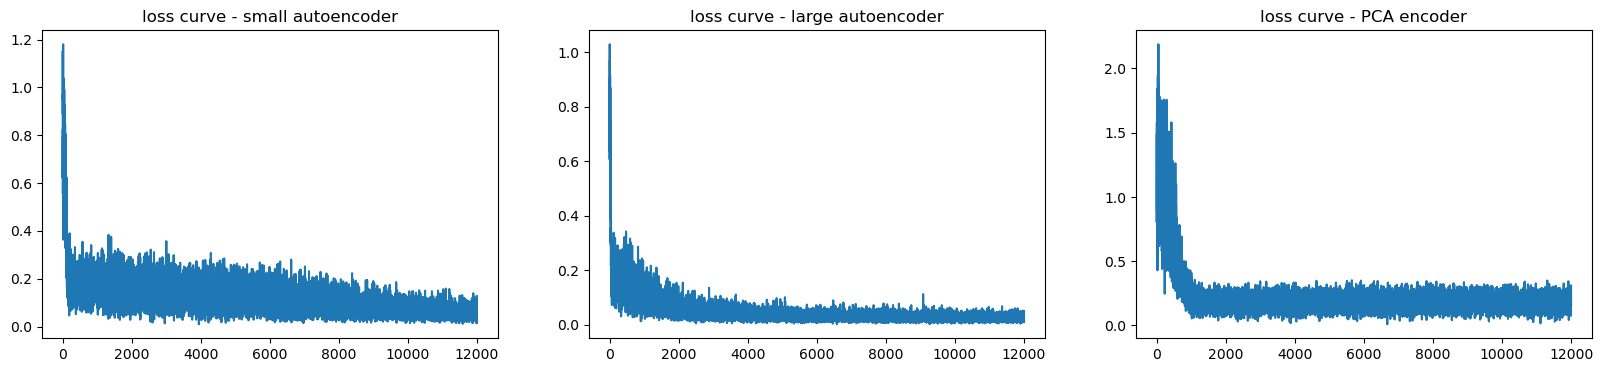

In [7]:
plt.rcParams["figure.figsize"] = (20,4)

plt.subplot(131)
plt.plot(autoencoder_module.loss_curve)
plt.title('loss curve - small autoencoder')

plt.subplot(132)
plt.plot(autoencoder_module2.loss_curve)
plt.title('loss curve - large autoencoder')

plt.subplot(133)
plt.plot(autoencoder_module3.loss_curve)
plt.title('loss curve - PCA encoder')
plt.show()

Larger autoencoder network have smaller loss and less oscillation in the late stage of training than the smaller one, which is again better than PCA.

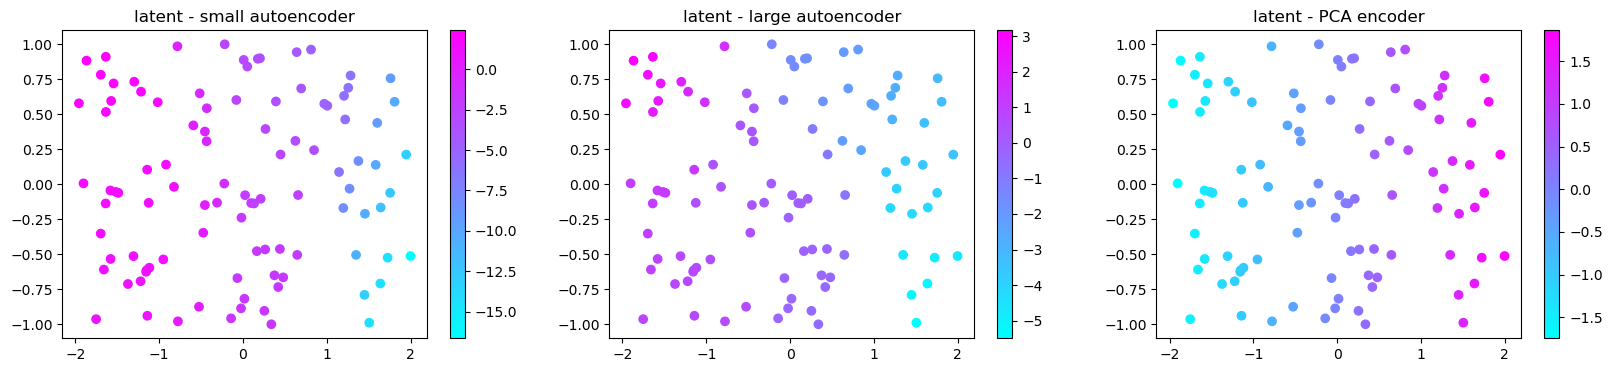

In [20]:
latent_1 = autoencoder_module.autoencoder.encoder(data)
latent_2 = autoencoder_module2.autoencoder.encoder(data)
latent_3 = autoencoder_module3.autoencoder.encoder(data)
plt.rcParams["figure.figsize"] = (20,4)
plt.subplot(131)
plt.scatter(data[:, 0], data[:, 1], c=latent_1[:, 0].detach().numpy(), cmap='cool')
plt.colorbar()
plt.title('latent - small autoencoder')

plt.subplot(132)
plt.scatter(data[:, 0], data[:, 1], c=latent_2[:, 0].detach().numpy(), cmap='cool')
plt.colorbar()
plt.title('latent - large autoencoder')

plt.subplot(133)
plt.scatter(data[:, 0], data[:, 1], c=latent_3[:, 0].detach().numpy(), cmap='cool')
plt.colorbar()
plt.title('latent - PCA encoder')
plt.show()

### c)

### Guess: 

#### Random initialization:

small autoencoder: a random curve,

large autoencoder: a slightly more complicated random curve,

PCA: a ramdom straight line.

#### After training:

small autoencoder: a curve close to some embedding shape of data,

large autoencoder: a slightly more complicated curve,

PCA: a straight line minimize loss.

### d)

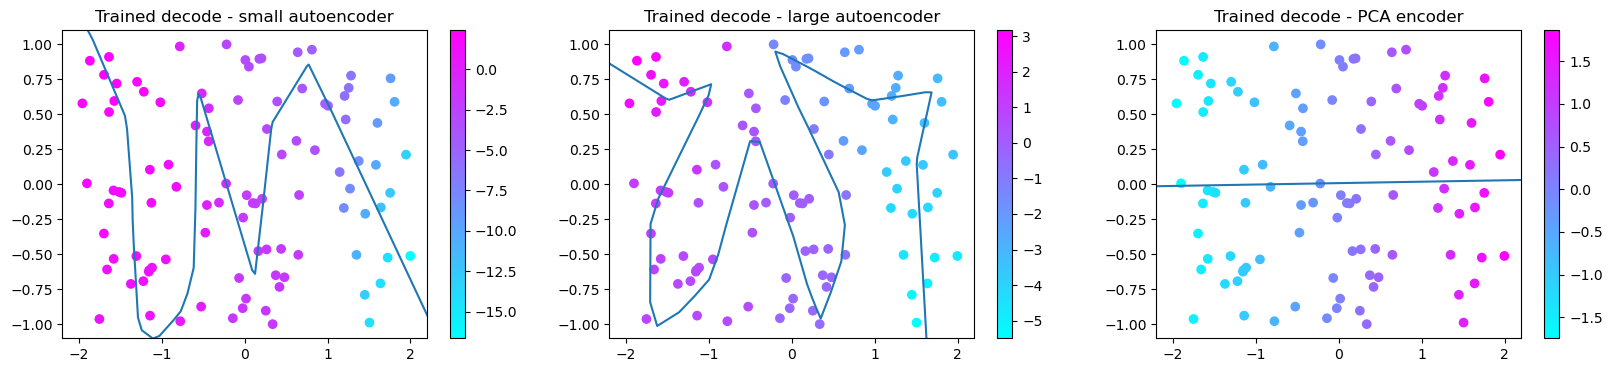

In [21]:
import numpy as np

x = torch.tensor(np.linspace(-20, 20, 500)).float().reshape(-1,1)

plt.rcParams["figure.figsize"] = (20,4)
plt.subplot(131)
ambient_1 = autoencoder_module.autoencoder.decoder(x)
plt.plot(ambient_1[:, 0].detach().numpy(), ambient_1[:, 1].detach().numpy())
plt.scatter(data[:, 0], data[:, 1], c=latent_1[:, 0].detach().numpy(), cmap='cool')
plt.xlim(-2.2, 2.2)
plt.ylim(-1.1, 1.1)
plt.title('Trained decode - small autoencoder')
plt.colorbar()

plt.subplot(132)
ambient_2 = autoencoder_module2.autoencoder.decoder(x)
plt.plot(ambient_2[:, 0].detach().numpy(), ambient_2[:, 1].detach().numpy())
plt.scatter(data[:, 0], data[:, 1], c=latent_2[:, 0].detach().numpy(), cmap='cool')
plt.xlim(-2.2, 2.2)
plt.ylim(-1.1, 1.1)
plt.title('Trained decode - large autoencoder')
plt.colorbar()

plt.subplot(133)
ambient_3 = autoencoder_module3.autoencoder.decoder(x)
plt.plot(ambient_3[:, 0].detach().numpy(), ambient_3[:, 1].detach().numpy())
plt.scatter(data[:, 0], data[:, 1], c=latent_3[:, 0].detach().numpy(), cmap='cool')
plt.xlim(-2.2, 2.2)
plt.ylim(-1.1, 1.1)
plt.title('Trained decode - PCA encoder')
plt.colorbar()
plt.show()

Autoencoders try to fit some intrinsic shape of samples, and larger network fits for a more complicated form.

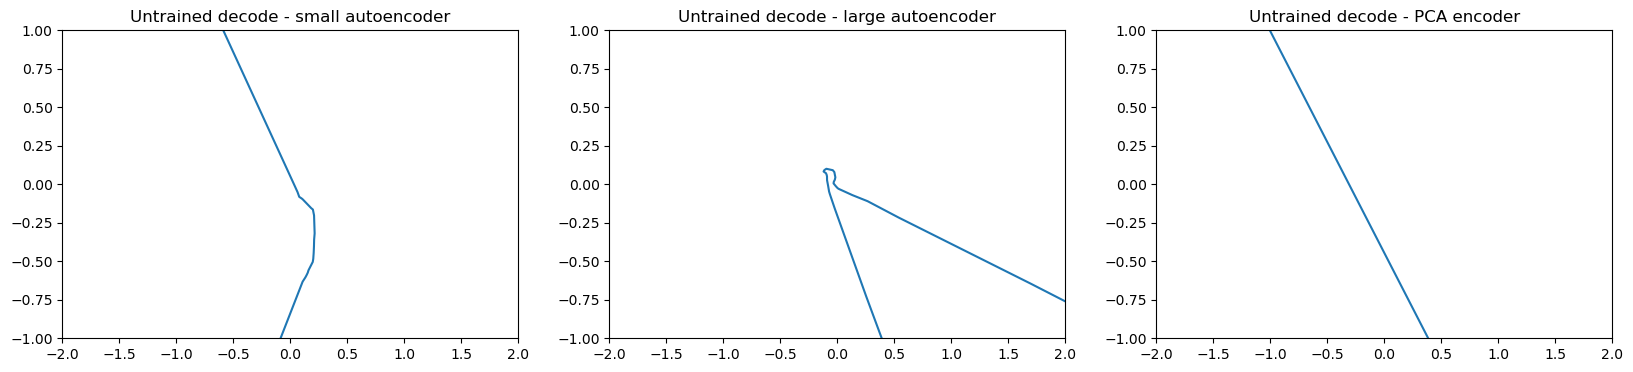

In [24]:
x = torch.tensor(np.linspace(-1000, 1000, 10000)).float().reshape(-1,1)

plt.rcParams["figure.figsize"] = (20,4)
plt.subplot(131)
autoencoder_module_tmp = AutoencoderModule(hidded_channels='AE1', latent_dim=1, input_dim=2)
ambient_1 = autoencoder_module_tmp.autoencoder.decoder(x)
plt.plot(ambient_1[:, 0].detach().numpy(), ambient_1[:, 1].detach().numpy())
plt.xlim(-2, 2)
plt.ylim(-1, 1)
plt.title('Untrained decode - small autoencoder')

plt.subplot(132)
autoencoder_module_tmp = AutoencoderModule(hidded_channels='AE2', latent_dim=1, input_dim=2)
ambient_2 = autoencoder_module_tmp.autoencoder.decoder(x)
plt.plot(ambient_2[:, 0].detach().numpy(), ambient_2[:, 1].detach().numpy())
plt.xlim(-2, 2)
plt.ylim(-1, 1)
plt.title('Untrained decode - large autoencoder')

plt.subplot(133)
autoencoder_module_tmp = AutoencoderModule(hidded_channels='PCA', latent_dim=1, input_dim=2)
ambient_3 = autoencoder_module_tmp.autoencoder.decoder(x)
plt.plot(ambient_3[:, 0].detach().numpy(), ambient_3[:, 1].detach().numpy())
plt.xlim(-2, 2)
plt.ylim(-1, 1)
plt.title('Untrained decode - PCA encoder')
plt.show()

### e)

Yes. Even though the network can't map a p-dimension space perfectly to a 1-d space without loss of information, but for a limited dataset with n points, only a limited number of features (i.e. n $\times$ p features) need to be mapped to the 1-d space, and this can be done perfectly. Therefore, if the network is complicated enough, and we include those n points to our training dataset, it is possible to perfectly reconstruct these points.

### f)

### g)

In [11]:
import re
import numpy as np
trainer = pl.Trainer(max_epochs=1000)
autoencoder_modulefix = AutoencoderModule(hidded_channels='AE2', latent_dim=1, input_dim=2)
print("Model overview:", autoencoder_modulefix)

trainer.fit(autoencoder_modulefix, data_loader)

latent_trained = autoencoder_modulefix.autoencoder.encoder(data)

params_encoder_trained = []
for name, param in autoencoder_modulefix.autoencoder.named_parameters():
    if re.match(r'^decoder\.', name) != None:
        param.requires_grad = False
    else:
        params_encoder_trained.append(param.detach().numpy().flatten())
        torch.nn.init.uniform_(param, -np.sqrt(param.shape[0]), np.sqrt(param.shape[0]))


trainer.fit(autoencoder_modulefix, data_loader)

params_encoder_retrained = []
for name, param in autoencoder_modulefix.autoencoder.named_parameters():
    if param.requires_grad == True:
        params_encoder_retrained.append(param.detach().numpy().flatten())


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 5.5 K  | train
----------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
/root/anaconda3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /mnt/c/Users/A90072180A/Documents/Study/Germany/UniHeidelbergLecture/ML and Physics/mlph_w24-main/sheet06/lightning_logs/version_39/checkpoints exists and is not empty.

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 5.5 K  | train
----------------------------------------------------
2.8 K     Trainable params
2.8 K     Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1000` reached.


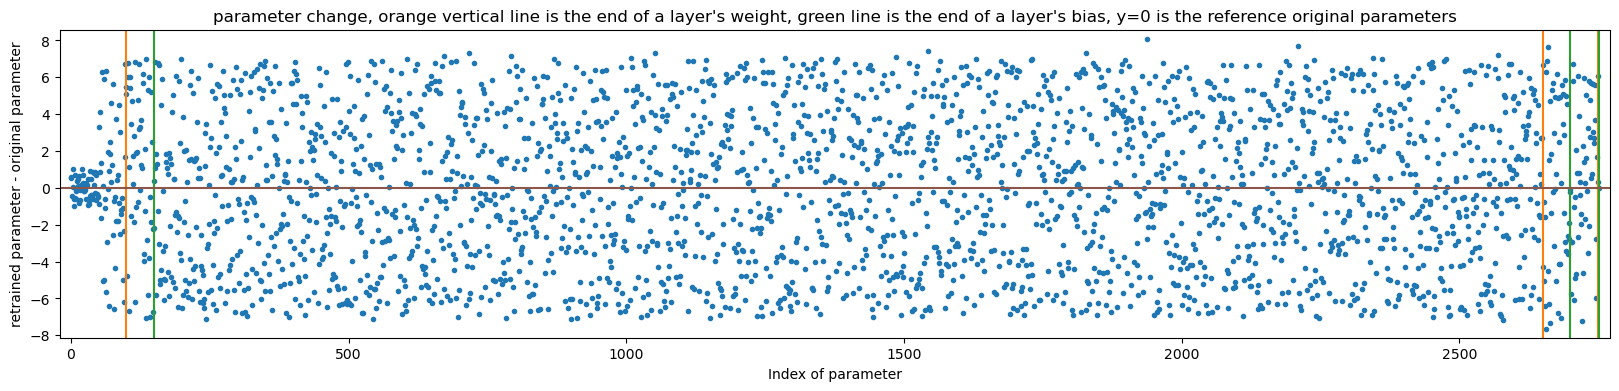

In [28]:
z0 = np.zeros((2, 1))
for x, y in zip(params_encoder_trained, params_encoder_retrained):
    z = np.stack((x, y))
    z0 = np.concatenate((z, z0), axis=-1)


plt.rcParams["figure.figsize"] = (20,4)
plt.scatter(range(len(z0[0])), z0[1] - z0[0], marker='.')
pos = 0
for name, param in autoencoder_modulefix.autoencoder.named_parameters():
    if param.requires_grad == True:
        pos += param.detach().numpy().flatten().shape[0]
        plt.vlines(pos, min(z0[1] - z0[0])-1, max(z0[1] - z0[0])+1, colors='C1' if re.search(r'bias$', name) == None else 'C2')
        
plt.hlines(0, -20, pos+20, colors='C5')
plt.title('parameter change, orange vertical line is the end of a layer\'s weight, green line is the end of a layer\'s bias, y=0 is the reference original parameters')
plt.xlim(-20, pos+20)
plt.ylim(min(z0[1] - z0[0])-0.5, max(z0[1] - z0[0])+0.5)
plt.xlabel('Index of parameter')
plt.ylabel('retrained parameter - original parameter')
plt.show()

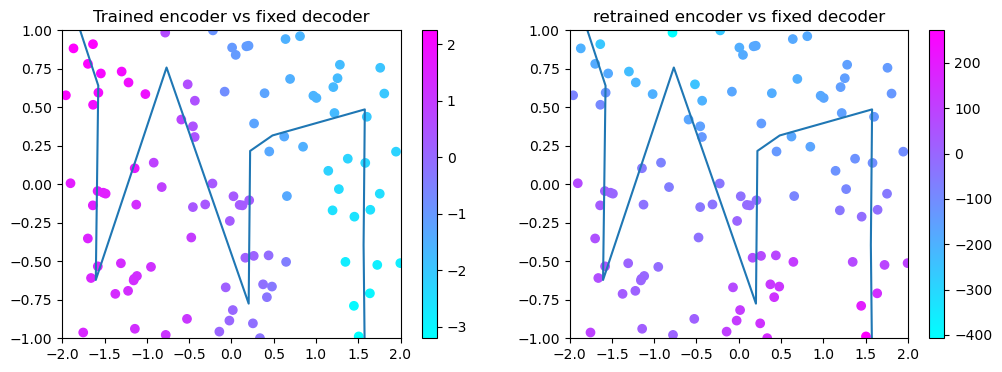

In [13]:
latent_retrained = autoencoder_modulefix.autoencoder.encoder(data)

x = torch.tensor(np.linspace(min(latent_retrained[:, 0].detach().numpy())-1, max(latent_retrained[:, 0].detach().numpy())+1, 1000)).float().reshape(-1,1)
ambient = autoencoder_modulefix.autoencoder.decoder(x)

plt.rcParams["figure.figsize"] = (12,4)
plt.subplot(121)
plt.scatter(data[:, 0], data[:, 1], c=latent_trained[:, 0].detach().numpy(), cmap='cool')
plt.plot(ambient[:, 0].detach().numpy(), ambient[:, 1].detach().numpy())
plt.xlim(-2, 2)
plt.ylim(-1, 1)
plt.colorbar()
plt.title('Trained encoder vs fixed decoder')

plt.subplot(122)
plt.scatter(data[:, 0], data[:, 1], c=latent_retrained[:, 0].detach().numpy(), cmap='cool')
plt.plot(ambient[:, 0].detach().numpy(), ambient[:, 1].detach().numpy())
plt.xlim(-2, 2)
plt.ylim(-1, 1)
plt.colorbar()
plt.title('retrained encoder vs fixed decoder')
plt.show()

In [14]:
class AutoencoderModule_SGD(pl.LightningModule):
    def __init__(self, **model_kwargs):
        super().__init__()
        self.autoencoder = Autoencoder(**model_kwargs)
        self.loss_curve = []

    def forward(self, x):
        return self.autoencoder(x)

    def configure_optimizers(self):
        # SGD / GD optimizer
        optimizer = torch.optim.SGD(self.parameters())

        return optimizer
    
    def on_train_start(self):
        self.loss_curve = []
        return super().on_train_start()

    def training_step(self, batch):
        x, _ = batch
        x_hat = self.autoencoder(x)
        loss = nn.MSELoss()(x_hat, x)
        self.loss_curve.append(loss.item())
        return loss

In [15]:
mini_batch_size = 8
data_loader_SGD = DataLoader(dataset, batch_size=mini_batch_size, shuffle=True, drop_last=True)
data_loader_GD = DataLoader(dataset, batch_size=num_samples, shuffle=True, drop_last=True)

In [16]:
trainer = pl.Trainer(max_epochs=1000)
autoencoder_moduleSGD = AutoencoderModule_SGD(hidded_channels='AE2', latent_dim=1, input_dim=2)

trainer.fit(autoencoder_moduleSGD, data_loader_SGD)

trainer = pl.Trainer(max_epochs=1000)
autoencoder_moduleGD = AutoencoderModule_SGD(hidded_channels='AE2', latent_dim=1, input_dim=2)

trainer.fit(autoencoder_moduleGD, data_loader_GD)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 5.5 K  | train
----------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 5.5 K  | train
----------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode
/root/anaconda3/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


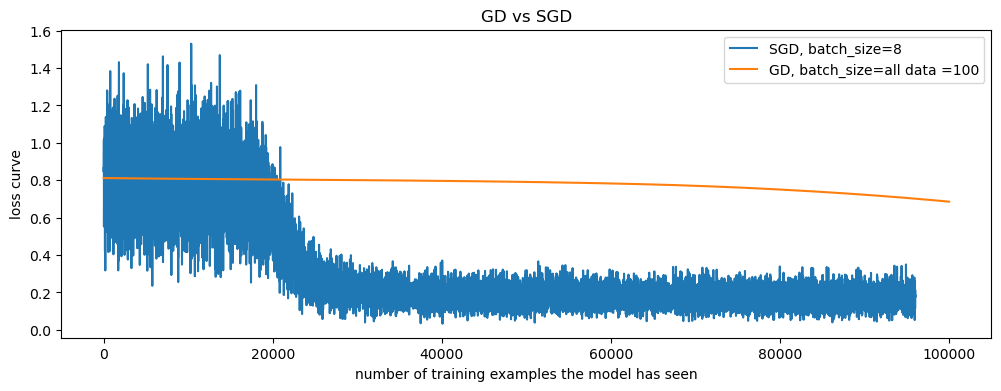

In [17]:
import numpy as np
xGD = np.linspace(0, len(autoencoder_moduleGD.loss_curve)*num_samples, len(autoencoder_moduleGD.loss_curve))
xSGD = np.linspace(0, len(autoencoder_moduleSGD.loss_curve)*mini_batch_size, len(autoencoder_moduleSGD.loss_curve))
plt.plot(xSGD, autoencoder_moduleSGD.loss_curve, label='SGD, batch_size='+str(mini_batch_size))
plt.plot(xGD, autoencoder_moduleGD.loss_curve, label='GD, batch_size=all data =' + str(num_samples))
plt.legend()
plt.xlabel('number of training examples the model has seen')
plt.ylabel('loss curve')
plt.title('GD vs SGD')
plt.show()

# 2 Training of an MLP

### a)

![image info](./Q2_screenshot/a.png)

### b)

### Without Regularization:
![image info](./Q2_screenshot/b_noRegular.png)

### L1 Regularization:
![image info](./Q2_screenshot/b_L1.png)

### L2 Regularization:
![image info](./Q2_screenshot/b_L2.png)

L1 regularization suppressed most of the parameters close to zero. In each layer, there are a few parameters with high values.

L2 regularization suppressed all parameters to small values.

This makes sense because L1 regularization tends to have sparse solution.

### c)
![image info](./Q2_screenshot/c.png)

We observe that when the training dataset is not large enough to include most of the features of all dataset, large scale networks tend to overfit and capture non general pattern in training dataset.